In [1]:
#importation des bibliothèques

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  roc_auc_score,accuracy_score
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import optuna
import matplotlib.pyplot as plt


c:\Users\lamou\Downloads\M2_MOSEF_S1\Data Mining\Projet_challenge\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#importation de la base de donnée

data_test=pd.read_csv("data\\test.csv",sep=',')
data_train=pd.read_csv("data\\train.csv",sep=',')

In [3]:
# Étape 1 : Préparez les données
X = data_train.drop(columns=['Exited'])  # Toutes les colonnes sauf 'Exited' pour les variables explicatives
y = data_train['Exited']  
X_test=data_test.copy()

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

Prepocessing

In [5]:
#encodage des varaibles qualitatives
features=['Geography', 'Gender']
ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore").set_output(transform="pandas")

ohe.fit(X_train[features])
X_train[ohe.get_feature_names_out(features)] = ohe.transform(X_train[features])
X_val[ohe.get_feature_names_out(features)] = ohe.transform(X_val[features])
X_test[ohe.get_feature_names_out(features)] = ohe.transform(X_test[features])
X_train=X_train.drop(columns=['Geography', 'Gender','Surname','CustomerId','id','Tenure','HasCrCard','Geography_Spain'])
X_val=X_val.drop(columns=['Geography', 'Gender','Surname','CustomerId','id','Tenure','HasCrCard','Geography_Spain'])
X_test=X_test.drop(columns=['Geography', 'Gender','Surname','CustomerId','id','Tenure','HasCrCard','Geography_Spain'])


In [6]:
X_test.head()

,CreditScore,Age,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Geography_Germany,Gender_Male
0,591.0,32.0,106881.50,2.0,0.0,122810.53,1.0,0.0
1,553.0,37.0,0.00,2.0,0.0,63736.17,0.0,1.0
2,646.0,29.0,0.00,2.0,0.0,121866.87,0.0,0.0
3,603.0,49.0,131394.56,1.0,1.0,147059.28,1.0,1.0
4,645.0,39.0,0.00,2.0,0.0,129975.94,0.0,0.0


In [7]:
def objective(trial):
    # Suggérez des valeurs pour les hyperparamètres
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False
    }
    
    # Initialisez le modèle avec les paramètres suggérés
    model = xgb.XGBClassifier(**param)
    
    # Entraînez le modèle
    model.fit(X_train, y_train)
    
    # Prédisez les probabilités pour l'ensemble de validation
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculez l'AUC
    auc_score = roc_auc_score(y_val, y_pred_proba)
    
    return auc_score

# Créez une étude et optimisez
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Affichez les meilleurs paramètres et le meilleur score
print("Best Hyperparameters:", study.best_params)
print("Best AUC Score:", study.best_value)

[I 2024-11-05 20:29:31,443] A new study created in memory with name: no-name-2e16c7b6-3f85-42d7-8479-e56d7c50e9ee
c:\Users\lamou\Downloads\M2_MOSEF_S1\Data Mining\Projet_challenge\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-11-05 20:29:31,885] Trial 0 finished with value: 0.9144664841728881 and parameters: {'max_depth': 9, 'learning_rate': 0.25845713570450607, 'n_estimators': 444, 'colsample_bytree': 0.7161464363267848, 'subsample': 0.6625530664255467, 'gamma': 0.3518502787014999, 'min_child_weight': 4}. Best is trial 0 with value: 0.9144664841728881.
c:\Users\lamou\Downloads\M2_MOSEF_S1\Data Mining\Projet_challenge\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:29:31] WARNING: C:\buildkite-agent\builds\buildkit

Best Hyperparameters: {'max_depth': 3, 'learning_rate': 0.048776767250820974, 'n_estimators': 353, 'colsample_bytree': 0.5483956838914464, 'subsample': 0.7247919946356973, 'gamma': 0.3226827051327965, 'min_child_weight': 1}
Best AUC Score: 0.9347749506403527


In [9]:
best_params = study.best_params

# Créez un modèle XGBoost avec les meilleurs paramètres
best_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

# Entraînez le modèle sur l'ensemble d'entraînement complet
best_model.fit(X_train, y_train)

# Prédisez les probabilités pour l'ensemble de test
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilité de churn (classe positive)

c:\Users\lamou\Downloads\M2_MOSEF_S1\Data Mining\Projet_challenge\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
from sklearn.model_selection import cross_val_score

# Créez un modèle XGBoost avec les meilleurs paramètres (sans "use_label_encoder")
best_model_final= xgb.XGBClassifier(**best_params, eval_metric='logloss')

# Entraînez le modèle
best_model_final.fit(X_train, y_train)

# Évaluation du modèle
cv_scores = cross_val_score(best_model_final, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validated AUC score:", cv_scores.mean())



Cross-validated AUC score: 0.937377039353944


In [12]:
y_test_pred_proba_best = best_model_final.predict_proba(X_test)[:, 1] 

In [14]:
sample_submission_test_best_final = data_test[['id']].copy()  # Copie uniquement la colonne 'id' de data_test
sample_submission_test_best_final["Exited"] = y_test_pred_proba_best  # Ajout des probabilités de churn

# Affichez les premières lignes de sample_submission pour vérification
print(sample_submission_test_best_final.head())

# Optionnel : Exportez sample_submission en CSV
sample_submission_test_best_final.to_csv("sample_submission_test_best_final.csv", index=False)

      id    Exited
0  15000  0.091520
1  15001  0.013212
2  15002  0.016375
3  15003  0.754407
4  15004  0.039337


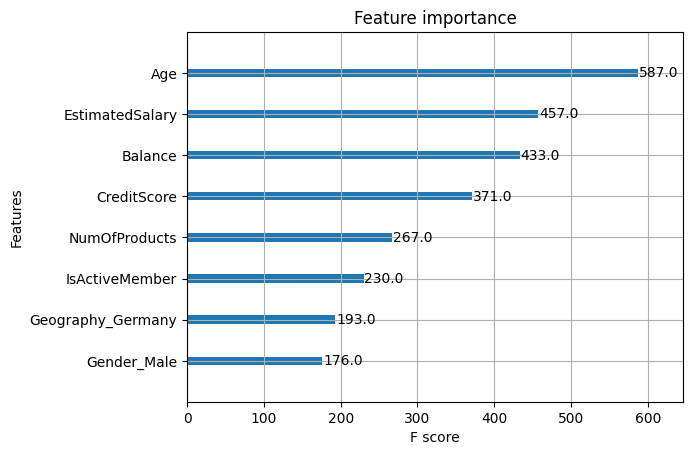

In [9]:
xgb.plot_importance(best_model, importance_type='weight')

# Ajustez la taille de la figure
plt.rcParams['figure.figsize'] = [6, 5]
plt.show()

In [10]:


# Étape 4 : Entraînez le modèle XGBoost
model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train, y_train)

# Étape 5 : Prédisez les probabilités pour l'ensemble de validation
y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilité pour la classe 1 (churn)
y_pred = model.predict(X_val)                     # Prédictions de classes pour d'autres métriques

# Calcul de l'AUC pour évaluer la capacité du modèle à distinguer entre churn et non-churn
auc_score = roc_auc_score(y_val, y_pred_proba)
print("AUC:", auc_score)

# Calcul de la précision
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

# Matrice de confusion pour mieux comprendre les erreurs de classification
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", conf_matrix)


c:\Users\lamou\Downloads\M2_MOSEF_S1\Data Mining\Projet_challenge\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:58:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC: 0.9085945349023219
Accuracy: 0.8786666666666667
Confusion Matrix:
 [[3409  194]
 [ 352  545]]


In [11]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [12]:
# Créez sample_submission en copiant l'identifiant 'id' de data_train pour les échantillons de validation
sample_submission = data_train[['id']].iloc[y_val.index].copy().reset_index(drop=True)

# Ajoutez la colonne 'Churn_Probability' de proba_df à sample_submission
sample_submission["Exited"] = y_pred_proba  # Ajout des probabilités de churn

# Affichez les premières lignes pour vérifier
print(sample_submission.head())


      id    Exited
0   4747  0.005146
1  11140  0.116594
2    404  0.156459
3   8707  0.041854
4   5046  0.008306


In [13]:
sample_submission.to_csv("sample_submission.csv",index=False)

In [14]:
sample_submission.shape

(4500, 2)

In [25]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 500],
    'colsample_bytree': [0.3, 0.7, 1.0],
    'subsample': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 5, 10]
}

model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=20, scoring='roc_auc', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred_proba_best = best_model.predict_proba(X_val)[:, 1]
auc_best = roc_auc_score(y_val, y_pred_proba_best)
print("Best AUC after hyperparameter tuning:", auc_best)


KeyboardInterrupt: 

In [20]:
from sklearn.model_selection import cross_val_score

model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validated AUC scores:", auc_scores)
print("Average AUC:", auc_scores.mean())


c:\Users\lamou\Downloads\M2_MOSEF_S1\Data Mining\Projet_challenge\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:51:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lamou\Downloads\M2_MOSEF_S1\Data Mining\Projet_challenge\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:51:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lamou\Downloads\M2_MOSEF_S1\Data Mining\Projet_challenge\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:51:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learn

Cross-validated AUC scores: [0.92274519 0.92698229 0.91865707 0.92311515 0.93091537]
Average AUC: 0.9244830133817155


In [26]:

y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Créez sample_submission avec 'id' et 'Churn_Probability'
sample_submission_test_best = data_test[['id']].copy()  # Copie uniquement la colonne 'id' de data_test
sample_submission_test_best["Exited"] = y_pred_proba_best  # Ajout des probabilités de churn

# Affichez les premières lignes de sample_submission pour vérification
print(sample_submission_test_best.head())

# Optionnel : Exportez sample_submission en CSV
sample_submission_test_best.to_csv("sample_submission_test_best.csv", index=False)


      id    Exited
0  15000  0.166050
1  15001  0.058086
2  15002  0.059625
3  15003  0.586088
4  15004  0.081252
